Notebook uses BedMachine Antarctica ice-surface and bed topographies to calculate and export subglacial hydropotential using the Shreve (1972) hydropotential equation.

Written 2025/05/19 by W. Sauthoff (wsauthoff.github.io) and M. R. Siegfried (mrsiegfried.github.io).

# TODO
* output continental scale hydropotential plot to repo; read into readme for visual

# Setup computing environment

In [1]:
# Import packages
import earthaccess
import fsspec
import json
import matplotlib.pyplot as plt
import numpy as np
from pyproj import CRS
import shutil
import xarray as xr
import zarr

%matplotlib widget

# Access data

In [2]:
# Direct-access stream BedMachine Antarctica bed and surface topography v3 (Morlighem et al., 2020; Morlighem, 2022)
# https://nsidc.org/data/NSIDC-0756
try:
    results = earthaccess.search_data(
        doi='10.5067/FPSU0V1MWUB6',
        cloud_hosted=True,
        # bounding_box=(1, -89, -1, -89)
    )
    
    if not results:
        raise ValueError('No datasets found matching the search criteria')
        
    # Open data granules as s3 files to stream
    files = earthaccess.open(results)
    
    # Check if files list is empty
    if not files:
        raise FileNotFoundError('No files were opened from the search results')
        
    # Check if first file exists/is valid
    if isinstance(files[0], FileNotFoundError):
        raise FileNotFoundError(f'Could not access file: {files[0]}')
        
    # Print file name to ensure expected dataset
    print(f'Attempting to open: {files[0]}')
    
    # Open file into xarray dataset
    bedmachine_original = xr.open_dataset(files[0], engine='netcdf4')
    print('Dataset successfully loaded')

except FileNotFoundError as e:
    print(f'File access error: {e}')
except ValueError as e:
    print(f'Search error: {e}')
except Exception as e:
    print(f'Unexpected error: {e}')

'''
Note: Search error: can only read bytes or file-like objects with engine='scipy' or 'h5netcdf' seems to indicate FileNotFoundError
'''

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Attempting to open: <File-like object S3FileSystem, nsidc-cumulus-prod-protected/MEASURES/NSIDC-0756/3/1970/01/01/BedMachineAntarctica-v3.nc>
Search error: can only read bytes or file-like objects with engine='scipy' or 'h5netcdf'


"\nNote: Search error: can only read bytes or file-like objects with engine='scipy' or 'h5netcdf' seems to indicate FileNotFoundError\n"

In [3]:
# Open local copy of file if streaming fails
bedmachine_original = xr.open_dataset('/home/jovyan/temp/BedMachineAntarctica-v3.nc')
bedmachine_original

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 178MB ...
    firn       (y, x) float32 711MB ...
    surface    (y, x) float32 711MB ...
    thickness  (y, x) float32 711MB ...
    bed        (y, x) float32 711MB ...
    errbed     (y, x) float32 711MB ...
    source     (y, x) int8 178MB ...
    dataid     (y, x) int8 178MB ...
    geoid      (y, x) int16 356MB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

# Data analysis
Use Shreve (1972) equation to calculate hydropotential using bed elevations and ice-surface elevations (less firn depth to get ice mass).

In [4]:
# Step 1: Compute hydropotential

# Use BedMachine bed topography for Zbed and surface topography (less firn) for Zsurf

# Define densities (rho) of ice and water
rho_ice = 917
rho_water = 997

# Calculate hydropotential
subglacial_hydropotential_kPa = (9.8 * ((rho_ice*(bedmachine_original['surface']-bedmachine_original['firn'])) + (rho_water-rho_ice)*bedmachine_original['bed'])) / 1e3

# Display xarray.Dataset metadata
subglacial_hydropotential_kPa

<xarray.DataArray (y: 13333, x: 13333)> Size: 711MB
array([[-4637.787 , -4641.4346, -4645.678 , ..., -3103.3513, -3108.075 ,
        -3112.8809],
       [-4634.423 , -4638.6743, -4642.923 , ..., -3107.0686, -3111.754 ,
        -3111.4878],
       [-4631.3237, -4635.563 , -4639.9814, ..., -3113.2336, -3115.2698,
        -3114.826 ],
       ...,
       [-3593.728 , -3580.3374, -3573.4116, ..., -2873.387 , -2873.8782,
        -2873.621 ],
       [-3605.8892, -3593.2144, -3597.3118, ..., -2871.7485, -2873.8672,
        -2873.666 ],
       [-3626.012 , -3618.005 , -3621.9846, ..., -2870.198 , -2872.369 ,
        -2872.8738]], dtype=float32)
Coordinates:
  * x        (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y        (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000

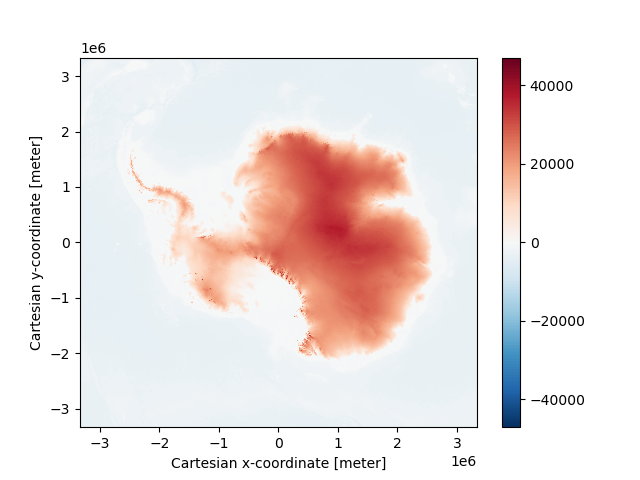

In [5]:
# Plot results
plt.figure()
subglacial_hydropotential_kPa.plot()
plt.show()

In [ ]:
# Step 2: Mask to grounded ice only

# Create a mask where values == 2 (grounded ice)
grounded_ice_mask = (bedmachine_original['mask'] == 2)

# Apply the mask to subglacial_hydropotential_kPa
subglacial_hydropotential_kPa = subglacial_hydropotential_kPa.where(grounded_ice_mask)

# Display xarray.Dataset metadata to ensure edges have become nan's
subglacial_hydropotential_kPa

# Export hydropotental dataset

In [ ]:
# Add metadata
subglacial_hydropotential_kPa.attrs = {
    'long_name': 'hydropotential',
    'units': 'kPa',
    'ice_density' : 917.0,
    'ice_density_units': 'kg m-3',
    'freshwater_density' : 997.0,
    'freshwater_density_units': 'kg m-3',
    'references': 'dois: 10.3189/S002214300002219X, 10.1038/s41561-019-0510-8, 10.5067/FPSU0V1MWUB6'
}

# Convert to dataset for chucking with Zarr
ds = subglacial_hydropotential_kPa.to_dataset(name='hydropotential')

# Add metadata
ds.attrs = {
    'conventions': 'CF-1.8',
    'title': 'Antarctic subglacial hydropotential derived from BedMachine Antarctica',
    'description': 'Antarctic subglacial gridded hydropotential calculated using Shreve (1972) equation using BedMachine Antarctica v3.4 bed and ice topographies and firn air content (Morlighem et al., 2020; Morlighem, 2022).',
    'history': 'Created 2025-05-19',
    # 'identifier_product_DOI': 'doi:',  # Awaiting first version release for Zenodo to mint DOI
    # 'citation': 'Sauthoff, W. & Siegfried, M. R. (2025). Antarctic subglacial hydropotential [Data set]. Zenodo. https://doi.org/XX',
    'license': 'CC BY-SA 4.0'
}

# Copy mapping variable into new dataset
ds['mapping'] = bedmachine_original['mapping']

# Link the mapping variable to variable
ds['hydropotential'].attrs['grid_mapping'] = 'mapping'

# Copy global CRS-related attributes
ds.attrs['proj4'] = bedmachine_original.attrs['proj4']
ds.attrs['Projection'] = bedmachine_original.attrs['Projection']

# Add crs and crs_wkt
ds.attrs['crs'] = 'EPSG:3031'
crs = CRS.from_epsg(3031)
ds.attrs['crs_wkt'] = crs.to_wkt()

# View ds metadata
ds

## Export to chucked netcdf

In [ ]:
# Export with chunking + compression
ds.to_netcdf(
    '/home/jovyan/temp/Antarctic_hydropotential.nc',
    encoding={
        'hydropotential': {
            '_FillValue': -9999.0,
            'dtype': 'float32',
            'zlib': True,
            'complevel': 4,
            'chunksizes': (500, 500)
        }
    }
)

## Validate dataset after export

In [ ]:
conda install -c conda-forge cfchecker  --quiet

In [ ]:
!cfchecks /home/jovyan/temp/Antarctic_hydropotential.nc

In [ ]:
print(ds['mapping'].dims)
print(ds['mapping'].shape)
print(ds['mapping'].attrs)

In [ ]:
import numpy as np
ds = ds.drop_vars('mapping', errors='ignore')
mapping_attrs = bedmachine_original['mapping'].attrs
ds['mapping'] = xr.DataArray(np.array(0, dtype=np.int32), attrs=mapping_attrs)

In [ ]:
# Export with chunking + compression
ds.to_netcdf(
    '/home/jovyan/temp/Antarctic_hydropotential.nc',
    encoding={
        'hydropotential': {
            'zlib': True,
            'complevel': 4,
            'chunksizes': (500, 500)
        }
    }
)

In [ ]:
!cfchecks /home/jovyan/temp/Antarctic_hydropotential.nc

In [ ]:
conda install -c conda-forge netcdf4  --quiet

In [ ]:
!ncdump -h /home/jovyan/temp/Antarctic_hydropotential.nc

In [ ]:
# Opened in QGIS and Panoply to ensure compatibility

## Export to Zarr

In [ ]:
# Chunk for performance (tune based on size and use case)
ds = ds.chunk({'x': 500, 'y': 500})

# Write to a Zarr store
ds.to_zarr('/home/jovyan/temp/Antarctic_hydropotential.zarr', mode='w')

In [ ]:
# ds = xr.open_zarr('/home/jovyan/temp/Antarctic_hydropotential.zarr', consolidated=False)
# ds.to_zarr('/home/jovyan/temp/Antarctic_hydropotential.zarr', mode="w", consolidated=True)

In [ ]:
# Consolidate metadata before zipping
zarr.consolidate_metadata('/home/jovyan/temp/Antarctic_hydropotential.zarr')

# Zip zarr files for upload to Zenodo
shutil.make_archive(
    '/home/jovyan/temp/Antarctic_hydropotential.zarr',  # output path (no zip extension)
    'zip',
    '/home/jovyan/temp/Antarctic_hydropotential.zarr'   # source
)

## Validate dataset after export

In [ ]:
ds_imported = xr.open_zarr('/home/jovyan/temp/Antarctic_hydropotential.zarr', consolidated=True)
ds_imported

In [ ]:
ds_imported.info()

In [ ]:
plt.figure()
ds_imported['hydropotential'].plot(vmin=0, vmax=40e3)
plt.show()

In [ ]:
print(ds_imported.coords)
print(ds_imported.attrs.get("crs"))
print(ds_imported.attrs.get("proj4"))
print(ds_imported["mapping"].attrs)
print(ds_imported["hydropotential"].attrs)

In [ ]:
print(ds_imported.chunks)

In [ ]:
# Open the ZIP file to ensure data reads in as expected
with open("/home/jovyan/temp/Antarctic_hydropotential.zarr.zip", "rb") as f:
    # Use fsspec's zip filesystem with that file object
    fs = fsspec.filesystem("zip", fo=f)
    
    # Since the Zarr store is at the root of the zip, root path is just ""
    mapper = fs.get_mapper("")
    
    ds = xr.open_zarr(mapper, consolidated=True)

# View dataset metadata
ds

Exported and validated data file saved to Zenodo repository (Sauthoff & Siegfriend, 2025). 

# Write .zenodo.json file
To write dataset metadata to Zenodo repo.

In [ ]:
zenodo_metadata = {
  "title": "Antarctic subglacial hydropotential derived from BedMachine Antarctica",
  "description": "Antarctic subglacial gridded hydropotential calculated using Shreve (1972) equation using BedMachine Antarctica bed and ice topographies and firn air content (Morlighem et al., 2020; Morlighem, 2022). The dataset provides calculated hydropotential (following Shreve, 1972) computed at 500 m resolution in EPSG:3031 (Polar Stereographic South) projection.",
  "creators": [
    {
      "name": "Sauthoff, Wilson",
      "affiliation": "Colorado School of Mines",
      "orcid": "0000-0001-9683-1578"
    },
    {
      "name": "Siegfried, Matthew R.",
      "affiliation": "Colorado School of Mines",
      "orcid": "0000-0002-0868-4633"
    }
  ],
  "upload_type": "dataset",
  "publication_date": "2025-05-19",
  "access_right": "open",
  "license": "CC-BY-SA-4.0",
  "keywords": [
    "Antarctica",
    "glaciology",
    "subglacial hydrology",
    "hydropotential"
  ],
  "related_identifiers": [
    {
      "identifier": "10.1038/s41561-019-0510-8",
      "relation": "isDerivedFrom",
      "resource_type": "publication"
    },
    {
      "identifier": "10.5067/FPSU0V1MWUB6",
      "relation": "isDerivedFrom",
      "resource_type": "dataset"
    },
    {
      "identifier": "10.3189/S002214300002219X",
      "relation": "references",
      "resource_type": "publication"
    }
  ],
  "communities": [
    {
      "identifier": "cryosphere"
    },
    {
      "identifier": "earthscience"
    }
  ],
  "subjects": [
    {
      "term": "Earth and Environmental Sciences",
      "identifier": "https://id.loc.gov/authorities/subjects/sh85040378"
    },
    {
      "term": "Glaciology",
      "identifier": "https://id.loc.gov/authorities/subjects/sh85055326"
    },
    {
      "term": "Antarctica",
      "identifier": "https://id.loc.gov/authorities/subjects/sh85005541"
    }
  ],
  "language": "eng",
  "version": "1.0.0",
  "notes": "This dataset contains a 500-m gridded Antarctic subglacial hydropotential derived from variables in the BedMachine Antarctica dataset. The hydropotential is provided in kilopascals (kPa) and is distributed in both NetCDF4 and Zarr formats.",
  "method": {
    "description": "Hydropotential was calculated using the Shreve (1972) equation, accounting for ice overburden pressure and bed elevation: θₕ = g × [(ρₘ-ρᵢ) × zₑ + ρᵢ × (z𝗌 - FAC)], where g=9.8 m/s², ρᵢ=917 kg/m³ (ice density), ρₘ=997 kg/m³ (water density), zₑ=bed elevation, z𝗌=ice surface, and FAC=firn air content."
  }
}

with open(".zenodo.json", "w") as f:
    json.dump(zenodo_metadata, f, indent=2)

# References

Morlighem, M., Rignot, E., Binder, T., Blankenship, D., Drews, R., Eagles, G., et al. (2020). Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet. Nature Geoscience, 13(2), 132–137. https://doi.org/10.1038/s41561-019-0510-8

Morlighem, M. (2022). MEaSUREs BedMachine Antarctica. (NSIDC-0756, Version 3). [Data Set]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/FPSU0V1MWUB6. Date Accessed 05-19-2025.

Sauthoff, W., & Siegfried, M. R. (2025). Antarctic subglacial hydropotential [Data set]. Zenodo. [DOI forthcoming]

Shreve, R. L. (1972). Movement of Water in Glaciers. _Journal of Glaciology_, 11(62), 205–214. https://doi.org/10.3189/S002214300002219X